In [88]:
# linear algebra and data processing
import numpy as np
import pandas as pd

# visualisations
import seaborn as sns
sns.set(rc={'figure.figsize':(12,7)})

import matplotlib.pyplot as plt

# logging
import logging
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

<h3>Data</h3>

In [89]:
train_df = pd.read_csv('../data/train.csv', dtype={'StateHoliday': object})
test_df = pd.read_csv('../data/test.csv')
store_df = pd.read_csv('../data/store.csv')
submission_df = pd.read_csv('../data/sample_submission.csv')

In [90]:
logging.info('train set shape: %s', train_df.shape)
logging.info('test set shape: %s', test_df.shape)
logging.info('store set shape: %s', store_df.shape)

2022-05-25 17:24:37,681 - root - INFO - train set shape: (1017209, 9)
2022-05-25 17:24:37,686 - root - INFO - test set shape: (41088, 8)
2022-05-25 17:24:37,693 - root - INFO - store set shape: (1115, 10)


In [91]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [92]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [93]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


<h5> Merge the train/test sets with the stores set </h5>

In [94]:
full_train_df = pd.merge(left= train_df, right=store_df, how='inner', left_on='Store', right_on='Store')
full_test_df = pd.merge(left= test_df, right=store_df, how='inner', left_on='Store', right_on='Store')

In [95]:
logging.info(full_train_df.shape)
logging.info(full_test_df.shape)

2022-05-25 17:24:39,684 - root - INFO - (1017209, 18)
2022-05-25 17:24:39,688 - root - INFO - (41088, 17)


<h4>Preprocessing</h4>

In [96]:
full_train_df.isna().any()

Store                        False
DayOfWeek                    False
Date                         False
Sales                        False
Customers                    False
Open                         False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                       False
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

In [97]:
full_train_df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [98]:
def preprocess_data(full_train_df, full_test_df):
    # dependent and independent variables
    global train_features, train_target, test_features
    train_features = full_train_df.drop(['Sales'], axis=1)
    train_target = full_train_df['Sales']
    test_features = full_test_df.drop(['Id'], axis=1)
    test_features['Customers'] = 0

    #feature generation + transformations
    def feature_generation(data):
        data['Date'] = pd.to_datetime(data.Date)
        data['Month'] = data.Date.dt.month.to_list()
        data['Year'] = data.Date.dt.year.to_list()
        data['Day'] = data.Date.dt.day.to_list()
        data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
        data['DayOfWeek'] = data.Date.dt.dayofweek.to_list()
        data['weekday'] = 1
        data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0
        data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0

        return data

    train_features = feature_generation(train_features)
    test_features = feature_generation(test_features)

    # numerical and categorical columns
    global categorical, numerical, timestamp
    categorical = []
    numerical = []
    timestamp = []

    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features])

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64')
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64')
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"

    # ''' actual preprocessing: '''
    # null values
    # numerical null values
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean())))

    # categorical null values
    for col in ['Open', 'PromoInterval']:
        features[col] = features[col].fillna(features[col].mode()[0])

    return features

In [99]:
features = preprocess_data(full_train_df, full_test_df)
logging.info(features.shape)
features.head()

/var/folders/68/y9l5p2ms1dz6vvvjggvffpbr0000gn/T/ipykernel_54749/274456982.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
/var/folders/68/y9l5p2ms1dz6vvvjggvffpbr0000gn/T/ipykernel_54749/274456982.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
/var/folders/68/y9l5p2ms1dz6vvvjggvffpbr0000gn/T/ipykernel_54749/274456982.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"
2022-05-25 17:24:56,066 - root - INFO - (1058297, 22)


,StateHoliday,StoreType,Assortment,PromoInterval,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Year,Day,WeekOfYear,weekday,Date
0,0,c,a,"Jan,Apr,Jul,Oct",1,4,555,1.0,1,1,...,2008,0,23,2011,7,2015,31,31,1,2015-07-31
1,0,c,a,"Jan,Apr,Jul,Oct",1,3,546,1.0,1,1,...,2008,0,23,2011,7,2015,30,31,1,2015-07-30
2,0,c,a,"Jan,Apr,Jul,Oct",1,2,523,1.0,1,1,...,2008,0,23,2011,7,2015,29,31,1,2015-07-29
3,0,c,a,"Jan,Apr,Jul,Oct",1,1,560,1.0,1,1,...,2008,0,23,2011,7,2015,28,31,1,2015-07-28
4,0,c,a,"Jan,Apr,Jul,Oct",1,0,612,1.0,1,1,...,2008,0,23,2011,7,2015,27,31,1,2015-07-27


In [100]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   StateHoliday               1058297 non-null  object        
 1   StoreType                  1058297 non-null  object        
 2   Assortment                 1058297 non-null  object        
 3   PromoInterval              1058297 non-null  object        
 4   Store                      1058297 non-null  int64         
 5   DayOfWeek                  1058297 non-null  int64         
 6   Customers                  1058297 non-null  int64         
 7   Open                       1058297 non-null  float64       
 8   Promo                      1058297 non-null  int64         
 9   SchoolHoliday              1058297 non-null  int64         
 10  CompetitionDistance        1058297 non-null  float64       
 11  CompetitionOpenSinceMonth  1058297 non-

In [101]:
numerical

['Store',
 'DayOfWeek',
 'Customers',
 'Open',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Month',
 'Year',
 'Day',
 'WeekOfYear',
 'weekday']

<h3>Reconstruct Train and Test sets</h3>

In [117]:
train_feat = features.iloc[:len(train_features), ]
test_feat = features.iloc[len(train_features):, :]
train_set = train_feat.copy()
test_set = test_feat.copy()
train_set['Sales'] = train_target
train_target.shape, train_feat.shape, train_set.shape, test_feat.shape

((1017209,), (1017209, 22), (1017209, 23), (41088, 22))

### Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

In [115]:
train_set.value_counts('Promo')

Promo
0    629129
1    388080
dtype: int64

In [118]:
test_set.value_counts('Promo')

Promo
0    24824
1    16264
dtype: int64

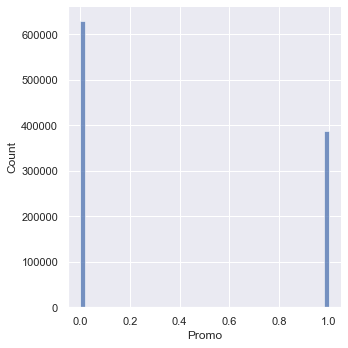

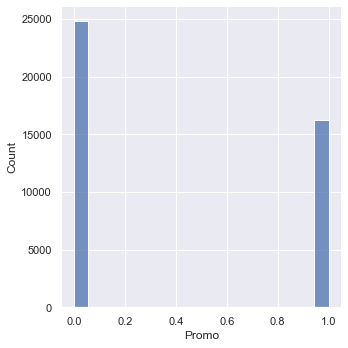

In [132]:
# fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,7))

sns.displot(x='Promo', data=train_set)
sns.displot(x='Promo', data=test_set)
# sns.barplot(x='Promo', y=train_set['Promo'].values_count()['data'], data=test_set, ax=axis2).set_title('')

### Check & compare sales behavior before, during and after holidays

<h3>Non-Graphical Analysis</h3>

In [123]:
train_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,2.998341,1.997391,0.0,1.0,3.0,5.0,6.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1017209.0,5430.049068,7705.297693,20.0,710.0,2330.0,6880.0,75860.0
CompetitionOpenSinceMonth,1017209.0,7.152022,2.654703,1.0,6.0,7.0,9.0,12.0
CompetitionOpenSinceYear,1017209.0,2008.470820,4.959791,1900.0,2008.0,2008.0,2011.0,2015.0
Promo2,1017209.0,0.500564,0.500000,0.0,0.0,1.0,1.0,1.0


<h3>Graphical Analysis</h3>

<h4>Correlation</h4>

top 6 features with highest correlation with sales


2022-05-25 17:39:32,757 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7f9b64530af0> <matplotlib.colors.Normalize object at 0x7f9b64530af0>
2022-05-25 17:39:32,770 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f9b64540dc0>
2022-05-25 17:39:32,779 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7f9b64530af0> <matplotlib.colors.Normalize object at 0x7f9b64530af0>
2022-05-25 17:39:32,791 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f9b64540dc0>
2022-05-25 17:39:32,813 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f9b645409a0>
2022-05-25 17:39:32,963 - matplotlib.axes._base - DEBUG - top of Axes not in the figure, so title not moved
2022-05-25 17:39:33,167 - matplotlib.axes._base - DEBUG - top of Axes not in the figure, so title not moved
2022-05-25 17:39:33,281 - matplotlib.axe

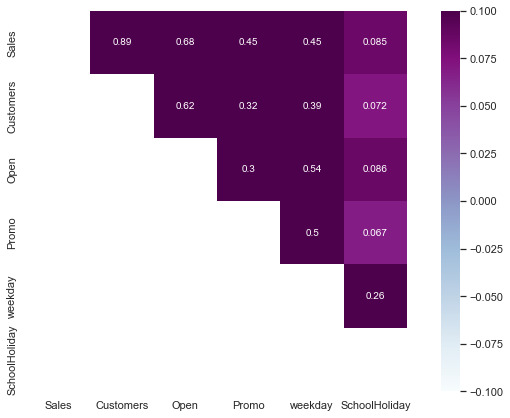

In [110]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number
                                               , f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()

    f_mask = np.zeros_like(f_correlation)
    f_mask[np.tril_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(12,7))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=0, square=True, annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

print('top 6 features with highest correlation with sales')
correlation_map(train_set, 'Sales', 6)

<strong>Sales and Customers have strong relationship</strong>

<h4>Bi-variant analysis</h4>

<strong>StateHoliday</strong>

/var/folders/68/y9l5p2ms1dz6vvvjggvffpbr0000gn/T/ipykernel_54749/4055540906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['StateHoliday'].loc[train_set['StateHoliday'] == 0] = "0"


Text(0.5, 1.0, 'State holidays value counts')

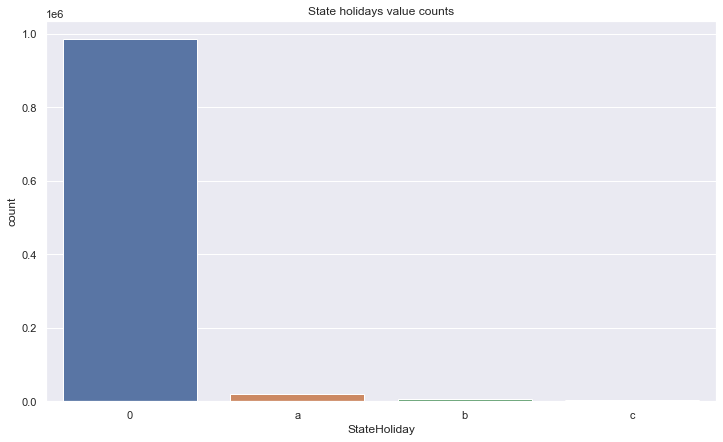

In [111]:
train_set['StateHoliday'].loc[train_set['StateHoliday'] == 0] = "0"
sns.countplot(x='StateHoliday', data=train_set).set_title('State holidays value counts')

Text(0.5, 1.0, 'sales during Stateholidays')

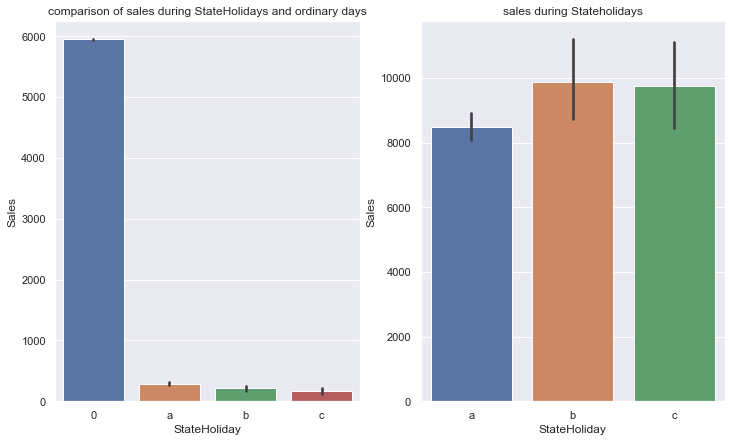

Text(0.5, 1.0, 'sales during Stateholidays')

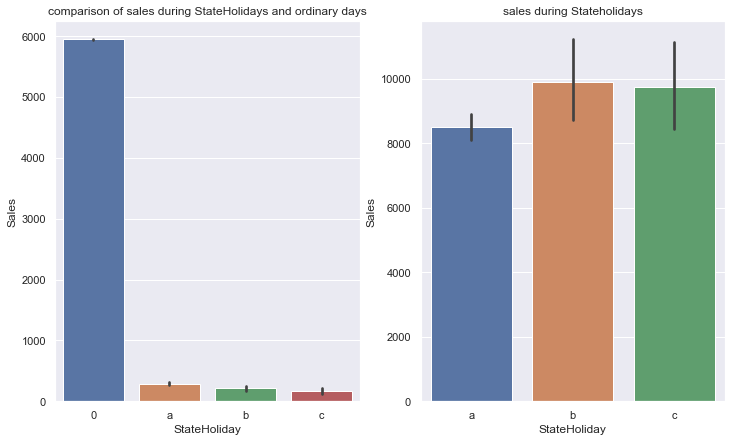

In [112]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,7))
sns.barplot(x='StateHoliday', y='Sales', data=train_set, ax=axis1).set_title('comparison of sales during StateHolidays and ordinary days')

mask = (train_set["StateHoliday"] != "0") & (train_set["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train_set[mask], ax=axis2).set_title('sales during Stateholidays')